In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [9]:
!python3 -c "import torch; print(torch.__version__)"

1.13.1


In [10]:
#!pip3 install torch torchvision
import torch
import torch.nn as nn
import numpy as np
from numpy import inf

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(0)

In [11]:
print(device)

cpu


In [12]:
threshold=10000
def act_fn(x):
    return torch.clamp(x, min=-threshold, max=threshold)

In [13]:
class GCNLayer(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        lim = 1  
        self.w_gcn = (-2 * lim * torch.rand(input_dim, output_dim) + lim).to(device)

    def forward(self, node_feats, adj_matrix):
        degrees = adj_matrix.sum(axis=0).to(device)
        adj_matrix = adj_matrix + torch.eye(len(adj_matrix)).to(device)
        normalization = torch.diag(1 / torch.sqrt(adj_matrix.sum(axis=0))).to(device)
        gcn_operator = torch.mm(torch.mm(normalization, adj_matrix), normalization).to(device)

        next_node_feats = torch.mm(torch.mm(gcn_operator, node_feats), 
                                 self.w_gcn).to(device)
        return next_node_feats.to(device)

In [14]:
class GCNModule(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, act_fn=act_fn):
        super().__init__()
        self.layers = nn.ModuleList([GCNLayer(input_dim, hidden_dim).to(device)])
        for i in range(num_layers - 2):
            self.layers.append(GCNLayer(hidden_dim, hidden_dim).to(device))
        self.layers.append(GCNLayer(hidden_dim, output_dim).to(device))
        self.act_fn = act_fn

    def forward(self, x, adj_matrix):
        for layer in self.layers:
            x = self.act_fn(layer(x, adj_matrix))
        return x

In [15]:
class MLPModule(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, act_fn=torch.tanh):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(input_dim, hidden_dim)]).to(device)
        for i in range(num_layers - 2):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim).to(device))
        self.layers.append(nn.Linear(hidden_dim, output_dim).to(device))
        self.act_fn = act_fn

    def forward(self, x):
        for layer in self.layers:
            x = self.act_fn(layer(x))
        return torch.sigmoid(x)

# Initial experiments

In [15]:
csv = []

for d in [128]:
    for r in [0.5]:
        for num_layers in [1,2,3]:
            for mpnn_idx in range(10):  # There will be 10 plots.
                # Initialize random BaseGNN model with sum aggregation.
                gcn = GCNModule(input_dim=d, hidden_dim=d, output_dim=d,
                                         num_layers=num_layers, act_fn=act_fn).to(device)

                # Initialize random MLP classifier acting on final mean-pooled embedding.
                mlp = MLPModule(input_dim=d, hidden_dim=100, output_dim=1, 
                            num_layers=2, act_fn=torch.tanh).to(device)

                torch.save(gcn,f"/content/drive/MyDrive/Colab Notebooks/partC/GNN0-1/GCN/gcn_num_{num_layers}_mpnn_{mpnn_idx}.pth")
                torch.save(mlp,f"/content/drive/MyDrive/Colab Notebooks/partC/GNN0-1/GCN/mlp_num_{num_layers}_mpnn_{mpnn_idx}.pth")

                # Keep track of proportions of graphs classified as 1.
                proportions = []

                # Create plot with x-axis an increasing seq of number of graph nodes.
                for graph_dim in [10, 50]:

                  # Generate 32 graphs for each such graph dimension, to keep
                  # track of the proportion that is classified as 1. 
                    classifications = []

                    for idx in range(2**5):
                        # Generate graph to be fed to the BaseGNN.
                        half_matrix = torch.bernoulli(r * (torch.triu(torch.ones(graph_dim, graph_dim)) -
                                              torch.eye(graph_dim)))
                        adj_matrix = half_matrix + half_matrix.T
                        initial_node_feats = torch.rand(graph_dim, d) 

                        # Obtain final mean-pooled embedding vector over all graph_dim nodes.
                        output = gcn(initial_node_feats, adj_matrix).mean(axis=0)
                        #print(output)

                        # Apply MLP classifier to the resulting output.
                        apply_classifier = mlp(output)

                        # If smaller than 1/2, output 0, else output 1.
                        if apply_classifier <= 0.5:
                            classifications.append(0)
                        else:
                            classifications.append(1)

                    # Calculate proportion of graphs classified as 1.
                    classifications = np.array(classifications)
                    proportions.append((classifications == 1).sum())

                csv.append([d,r,num_layers, mpnn_idx, proportions])
                print(csv[-1])


[128, 0.5, 1, 0, [30, 31]]
[128, 0.5, 1, 1, [7, 17]]
[128, 0.5, 1, 2, [17, 8]]
[128, 0.5, 1, 3, [2, 0]]
[128, 0.5, 1, 4, [0, 0]]
[128, 0.5, 1, 5, [32, 32]]
[128, 0.5, 1, 6, [0, 0]]
[128, 0.5, 1, 7, [0, 0]]
[128, 0.5, 1, 8, [32, 32]]
[128, 0.5, 1, 9, [8, 3]]
[128, 0.5, 2, 0, [0, 0]]
[128, 0.5, 2, 1, [0, 0]]
[128, 0.5, 2, 2, [32, 32]]
[128, 0.5, 2, 3, [0, 0]]
[128, 0.5, 2, 4, [3, 1]]
[128, 0.5, 2, 5, [15, 22]]
[128, 0.5, 2, 6, [0, 0]]
[128, 0.5, 2, 7, [31, 32]]
[128, 0.5, 2, 8, [0, 0]]
[128, 0.5, 2, 9, [32, 32]]
[128, 0.5, 3, 0, [32, 32]]
[128, 0.5, 3, 1, [0, 1]]
[128, 0.5, 3, 2, [5, 3]]
[128, 0.5, 3, 3, [13, 24]]
[128, 0.5, 3, 4, [27, 32]]
[128, 0.5, 3, 5, [32, 32]]
[128, 0.5, 3, 6, [6, 4]]
[128, 0.5, 3, 7, [32, 32]]
[128, 0.5, 3, 8, [32, 32]]
[128, 0.5, 3, 9, [32, 32]]


# Preferential Attachment

In [10]:
!pip3 install networkx


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [11]:
import networkx as nx
G = nx.barabasi_albert_graph(10, 2, seed=0)
A = nx.adjacency_matrix(G)
print(A.todense())

[[0 1 1 1 1 1 0 0 1 1]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0 0 0 0]
 [1 0 1 0 1 1 0 1 0 1]
 [1 0 0 1 0 0 1 0 1 0]
 [1 0 0 1 0 0 1 0 0 0]
 [0 0 0 0 1 1 0 1 0 0]
 [0 0 0 1 0 0 1 0 0 0]
 [1 0 0 0 1 0 0 0 0 0]
 [1 0 0 1 0 0 0 0 0 0]]


In [ ]:
csv = []

for d in [128]:
    for r in [0.5]:
        for num_layers in [1,2,3]:
            for mpnn_idx in range(10):  # There will be 10 plots.
                # Initialize random BaseGNN model with sum aggregation.
                gcn = GCNModule(input_dim=d, hidden_dim=d, output_dim=d,
                                         num_layers=num_layers, act_fn=act_fn).to(device)

                # Initialize random MLP classifier acting on final mean-pooled embedding.
                mlp = MLPModule(input_dim=d, hidden_dim=100, output_dim=1, 
                            num_layers=2, act_fn=torch.tanh).to(device)

                #torch.save(gcn,f"/Users/.../Desktop/.../pa_gcn_num_{num_layers}_mpnn_{mpnn_idx}.pth")
                #torch.save(mlp,f"/Users/.../Desktop/.../pa_mlp_num_{num_layers}_mpnn_{mpnn_idx}.pth")

                # Keep track of proportions of graphs classified as 1.
                proportions = []

                # Create plot with x-axis an increasing seq of number of graph nodes.
                for graph_dim in [10, 50, 100, 500, 1000, 2000, 5000]:
                    print(graph_dim)

                  # Generate 32 graphs for each such graph dimension, to keep
                  # track of the proportion that is classified as 1. 
                    classifications = []

                    for idx in range(2**5):
                        # Generate graph to be fed to the BaseGNN.
                        # half_matrix = torch.bernoulli(r * (torch.triu(torch.ones(graph_dim, graph_dim)) -
                        #                       torch.eye(graph_dim)))
                        # adj_matrix = half_matrix + half_matrix.T
                        G = nx.barabasi_albert_graph(graph_dim, graph_dim // 2)
                        A = nx.adjacency_matrix(G)
                        adj_matrix = torch.tensor(A.todense()).to(device)

                        initial_node_feats = torch.rand(graph_dim, d).to(device)

                        # Obtain final mean-pooled embedding vector over all graph_dim nodes.
                        output = gcn(initial_node_feats, adj_matrix).mean(axis=0)
                        #print(output)

                        # Apply MLP classifier to the resulting output.
                        apply_classifier = mlp(output)

                        # If smaller than 1/2, output 0, else output 1.
                        if apply_classifier <= 0.5:
                            classifications.append(0)
                        else:
                            classifications.append(1)

                    # Calculate proportion of graphs classified as 1.
                    classifications = np.array(classifications)
                    proportions.append((classifications == 1).sum())

                csv.append([d,r,num_layers, mpnn_idx, proportions])
                print(csv[-1])


10
50
100
500
1000
2000
5000


# Features sampled from different distributions than uniform

In [8]:
csv = []

for d in [128]:
    for r in [0.5]:
        for num_layers in [1,2,3]:
            for mpnn_idx in range(10):  # There will be 10 plots.
                # Initialize random BaseGNN model with sum aggregation.
                gcn = GCNModule(input_dim=d, hidden_dim=d, output_dim=d,
                                         num_layers=num_layers, act_fn=act_fn)

                # Initialize random MLP classifier acting on final mean-pooled embedding.
                mlp = MLPModule(input_dim=d, hidden_dim=100, output_dim=1, 
                            num_layers=2, act_fn=torch.tanh)

                #torch.save(gcn,f"/Users/.../Desktop/.../normal_gcn_num_{num_layers}_mpnn_{mpnn_idx}.pth")
                #torch.save(mlp,f"/Users/.../Desktop/.../normal_mlp_num_{num_layers}_mpnn_{mpnn_idx}.pth")

                # Keep track of proportions of graphs classified as 1.
                proportions = []

                # Create plot with x-axis an increasing seq of number of graph nodes.
                for graph_dim in [10, 50, 100, 500, 1000, 2000, 5000]:
                    print(graph_dim)

                  # Generate 32 graphs for each such graph dimension, to keep
                  # track of the proportion that is classified as 1. 
                    classifications = []

                    for idx in range(2**5):
                        # Generate graph to be fed to the BaseGNN.
                        half_matrix = torch.bernoulli(r * (torch.triu(torch.ones(graph_dim, graph_dim)) -
                                              torch.eye(graph_dim)))
                        adj_matrix = half_matrix + half_matrix.T
                        #initial_node_feats = torch.rand(graph_dim, d)
                        initial_node_feats = torch.normal(0.5, 1, size=(graph_dim, d))

                        # Obtain final mean-pooled embedding vector over all graph_dim nodes.
                        output = gcn(initial_node_feats, adj_matrix).mean(axis=0)
                        #print(output)

                        # Apply MLP classifier to the resulting output.
                        apply_classifier = mlp(output)

                        # If smaller than 1/2, output 0, else output 1.
                        if apply_classifier <= 0.5:
                            classifications.append(0)
                        else:
                            classifications.append(1)

                    # Calculate proportion of graphs classified as 1.
                    classifications = np.array(classifications)
                    proportions.append((classifications == 1).sum())

                csv.append([d,r,num_layers, mpnn_idx, proportions])
                print(csv[-1])


10
50
100
500
1000
2000
5000
[128, 0.5, 1, 0, [17, 10, 16, 22, 23, 29, 32]]
10
50
100
500
1000
2000
5000
[128, 0.5, 1, 1, [23, 32, 32, 32, 32, 32, 32]]
10
50
100
500
1000
2000
5000
[128, 0.5, 1, 2, [11, 10, 7, 9, 13, 10, 4]]
10
50
100
500
1000
2000
5000
[128, 0.5, 1, 3, [29, 32, 31, 32, 32, 32, 32]]
10
50
100
500
1000
2000
5000
[128, 0.5, 1, 4, [14, 10, 10, 2, 0, 0, 0]]
10
50
100
500
1000
2000
5000
[128, 0.5, 1, 5, [31, 32, 32, 32, 32, 32, 32]]
10
50
100
500
1000
2000
5000
[128, 0.5, 1, 6, [8, 16, 7, 7, 2, 1, 0]]
10
50
100
500
1000
2000
5000
[128, 0.5, 1, 7, [11, 11, 4, 1, 0, 0, 0]]
10
50
100
500
1000
2000
5000
[128, 0.5, 1, 8, [32, 32, 32, 32, 32, 32, 32]]
10
50
100
500
1000
2000
5000
[128, 0.5, 1, 9, [28, 32, 32, 32, 32, 32, 32]]
10
50
100
500
1000
2000
5000
[128, 0.5, 2, 0, [5, 3, 0, 0, 0, 0, 0]]
10
50
100
500
1000
2000
5000
[128, 0.5, 2, 1, [12, 11, 6, 6, 7, 4, 0]]
10
50
100
500
1000
2000
5000
[128, 0.5, 2, 2, [1, 0, 0, 0, 0, 0, 0]]
10
50
100
500
1000
2000
5000
[128, 0.5, 2, 3, [0,

In [16]:
csv

[[128, 0.5, 1, 0, [17, 10, 16, 22, 23, 29, 32]],
 [128, 0.5, 1, 1, [23, 32, 32, 32, 32, 32, 32]],
 [128, 0.5, 1, 2, [11, 10, 7, 9, 13, 10, 4]],
 [128, 0.5, 1, 3, [29, 32, 31, 32, 32, 32, 32]],
 [128, 0.5, 1, 4, [14, 10, 10, 2, 0, 0, 0]],
 [128, 0.5, 1, 5, [31, 32, 32, 32, 32, 32, 32]],
 [128, 0.5, 1, 6, [8, 16, 7, 7, 2, 1, 0]],
 [128, 0.5, 1, 7, [11, 11, 4, 1, 0, 0, 0]],
 [128, 0.5, 1, 8, [32, 32, 32, 32, 32, 32, 32]],
 [128, 0.5, 1, 9, [28, 32, 32, 32, 32, 32, 32]],
 [128, 0.5, 2, 0, [5, 3, 0, 0, 0, 0, 0]],
 [128, 0.5, 2, 1, [12, 11, 6, 6, 7, 4, 0]],
 [128, 0.5, 2, 2, [1, 0, 0, 0, 0, 0, 0]],
 [128, 0.5, 2, 3, [0, 1, 0, 0, 0, 0, 0]],
 [128, 0.5, 2, 4, [2, 0, 0, 0, 0, 0, 0]],
 [128, 0.5, 2, 5, [27, 32, 32, 32, 32, 32, 32]],
 [128, 0.5, 2, 6, [16, 4, 1, 0, 0, 0, 0]],
 [128, 0.5, 2, 7, [21, 16, 19, 18, 19, 17, 17]],
 [128, 0.5, 2, 8, [11, 7, 5, 1, 0, 0, 0]],
 [128, 0.5, 2, 9, [5, 7, 5, 1, 0, 0, 0]],
 [128, 0.5, 3, 0, [9, 11, 15, 23, 25, 26, 29]],
 [128, 0.5, 3, 1, [21, 28, 32, 32, 32, 32,

# r decreases as function of n

In [ ]:
csv = []

for d in [128]:
    for r in [0.5]:
        for num_layers in [1,2,3]:
            for mpnn_idx in range(10):  # There will be 10 plots.
                # Initialize random BaseGNN model with sum aggregation.
                gcn = GCNModule(input_dim=d, hidden_dim=d, output_dim=d,
                                         num_layers=num_layers, act_fn=act_fn)

                # Initialize random MLP classifier acting on final mean-pooled embedding.
                mlp = MLPModule(input_dim=d, hidden_dim=100, output_dim=1, 
                            num_layers=2, act_fn=torch.tanh)

                torch.save(gcn,f"/content/drive/MyDrive/Colab Notebooks/partC/GNN0-1/GCN/gcn_num_{num_layers}_mpnn_{mpnn_idx}.pth")
                torch.save(mlp,f"/content/drive/MyDrive/Colab Notebooks/partC/GNN0-1/GCN/mlp_num_{num_layers}_mpnn_{mpnn_idx}.pth")

                # Keep track of proportions of graphs classified as 1.
                proportions = []

                # Create plot with x-axis an increasing seq of number of graph nodes.
                for graph_dim in [10, 50]:

                  # Generate 32 graphs for each such graph dimension, to keep
                  # track of the proportion that is classified as 1. 
                    classifications = []

                    for idx in range(2**5):
                        # Generate graph to be fed to the BaseGNN.
                        half_matrix = torch.bernoulli(r * (torch.triu(torch.ones(graph_dim, graph_dim)) -
                                              torch.eye(graph_dim)))
                        adj_matrix = half_matrix + half_matrix.T
                        initial_node_feats = torch.rand(graph_dim, d) 

                        # Obtain final mean-pooled embedding vector over all graph_dim nodes.
                        output = gcn(initial_node_feats, adj_matrix).mean(axis=0)
                        #print(output)

                        # Apply MLP classifier to the resulting output.
                        apply_classifier = mlp(output)

                        # If smaller than 1/2, output 0, else output 1.
                        if apply_classifier <= 0.5:
                            classifications.append(0)
                        else:
                            classifications.append(1)

                    # Calculate proportion of graphs classified as 1.
                    classifications = np.array(classifications)
                    proportions.append((classifications == 1).sum())

                csv.append([d,r,num_layers, mpnn_idx, proportions])
                print(csv[-1])


# Different nonlinearities

In [ ]:
csv = []

for d in [128]:
    for r in [0.5]:
        for num_layers in [1,2,3]:
            for mpnn_idx in range(10):  # There will be 10 plots.
                # Initialize random BaseGNN model with sum aggregation.
                gcn = GCNModule(input_dim=d, hidden_dim=d, output_dim=d,
                                         num_layers=num_layers, act_fn=act_fn)

                # Initialize random MLP classifier acting on final mean-pooled embedding.
                mlp = MLPModule(input_dim=d, hidden_dim=100, output_dim=1, 
                            num_layers=2, act_fn=torch.tanh)

                torch.save(gcn,f"/content/drive/MyDrive/Colab Notebooks/partC/GNN0-1/GCN/gcn_num_{num_layers}_mpnn_{mpnn_idx}.pth")
                torch.save(mlp,f"/content/drive/MyDrive/Colab Notebooks/partC/GNN0-1/GCN/mlp_num_{num_layers}_mpnn_{mpnn_idx}.pth")

                # Keep track of proportions of graphs classified as 1.
                proportions = []

                # Create plot with x-axis an increasing seq of number of graph nodes.
                for graph_dim in [10, 50]:

                  # Generate 32 graphs for each such graph dimension, to keep
                  # track of the proportion that is classified as 1. 
                    classifications = []

                    for idx in range(2**5):
                        # Generate graph to be fed to the BaseGNN.
                        half_matrix = torch.bernoulli(r * (torch.triu(torch.ones(graph_dim, graph_dim)) -
                                              torch.eye(graph_dim)))
                        adj_matrix = half_matrix + half_matrix.T
                        initial_node_feats = torch.rand(graph_dim, d) 

                        # Obtain final mean-pooled embedding vector over all graph_dim nodes.
                        output = gcn(initial_node_feats, adj_matrix).mean(axis=0)
                        #print(output)

                        # Apply MLP classifier to the resulting output.
                        apply_classifier = mlp(output)

                        # If smaller than 1/2, output 0, else output 1.
                        if apply_classifier <= 0.5:
                            classifications.append(0)
                        else:
                            classifications.append(1)

                    # Calculate proportion of graphs classified as 1.
                    classifications = np.array(classifications)
                    proportions.append((classifications == 1).sum())

                csv.append([d,r,num_layers, mpnn_idx, proportions])
                print(csv[-1])


# virtual node

In [ ]:
csv = []

for d in [128]:
    for r in [0.5]:
        for num_layers in [1,2,3]:
            for mpnn_idx in range(10):  # There will be 10 plots.
                # Initialize random BaseGNN model with sum aggregation.
                gcn = GCNModule(input_dim=d, hidden_dim=d, output_dim=d,
                                         num_layers=num_layers, act_fn=act_fn)

                # Initialize random MLP classifier acting on final mean-pooled embedding.
                mlp = MLPModule(input_dim=d, hidden_dim=100, output_dim=1, 
                            num_layers=2, act_fn=torch.tanh)

                torch.save(gcn,f"/content/drive/MyDrive/Colab Notebooks/partC/GNN0-1/GCN/gcn_num_{num_layers}_mpnn_{mpnn_idx}.pth")
                torch.save(mlp,f"/content/drive/MyDrive/Colab Notebooks/partC/GNN0-1/GCN/mlp_num_{num_layers}_mpnn_{mpnn_idx}.pth")

                # Keep track of proportions of graphs classified as 1.
                proportions = []

                # Create plot with x-axis an increasing seq of number of graph nodes.
                for graph_dim in [10, 50]:

                  # Generate 32 graphs for each such graph dimension, to keep
                  # track of the proportion that is classified as 1. 
                    classifications = []

                    for idx in range(2**5):
                        # Generate graph to be fed to the BaseGNN.
                        half_matrix = torch.bernoulli(r * (torch.triu(torch.ones(graph_dim, graph_dim)) -
                                              torch.eye(graph_dim)))
                        adj_matrix = half_matrix + half_matrix.T
                        initial_node_feats = torch.rand(graph_dim, d) 

                        # Obtain final mean-pooled embedding vector over all graph_dim nodes.
                        output = gcn(initial_node_feats, adj_matrix).mean(axis=0)
                        #print(output)

                        # Apply MLP classifier to the resulting output.
                        apply_classifier = mlp(output)

                        # If smaller than 1/2, output 0, else output 1.
                        if apply_classifier <= 0.5:
                            classifications.append(0)
                        else:
                            classifications.append(1)

                    # Calculate proportion of graphs classified as 1.
                    classifications = np.array(classifications)
                    proportions.append((classifications == 1).sum())

                csv.append([d,r,num_layers, mpnn_idx, proportions])
                print(csv[-1])


In [17]:
import matplotlib.pyplot as plt
import pickle
#generate 3 images
csv_numLayer_1 = [item[-1] for item in csv if item[2] == 1]
csv_numLayer_2 = [item[-1] for item in csv if item[2] == 2]
csv_numLayer_3 = [item[-1] for item in csv if item[2] == 3]

In [18]:
#path_1 = f"/Users/.../Desktop/.../normal1_gcn_num_1.pickle"
with open(path_1, 'wb') as handle:
    pickle.dump(csv_numLayer_1,handle)

#path_2 = f"/Users/.../Desktop/.../normal1_gcn_num_2.pickle"
with open(path_2, 'wb') as handle:
    pickle.dump(csv_numLayer_2,handle)

#path_3 = f"/Users/.../Desktop/.../normal1_gcn_num_3.pickle"
with open(path_3, 'wb') as handle:
    pickle.dump(csv_numLayer_3,handle)

In [19]:
plt.rcParams['figure.dpi'] = 600

In [20]:
x = [10, 50, 100, 500, 1000, 2000, 5000]
#x = [10,50,100]

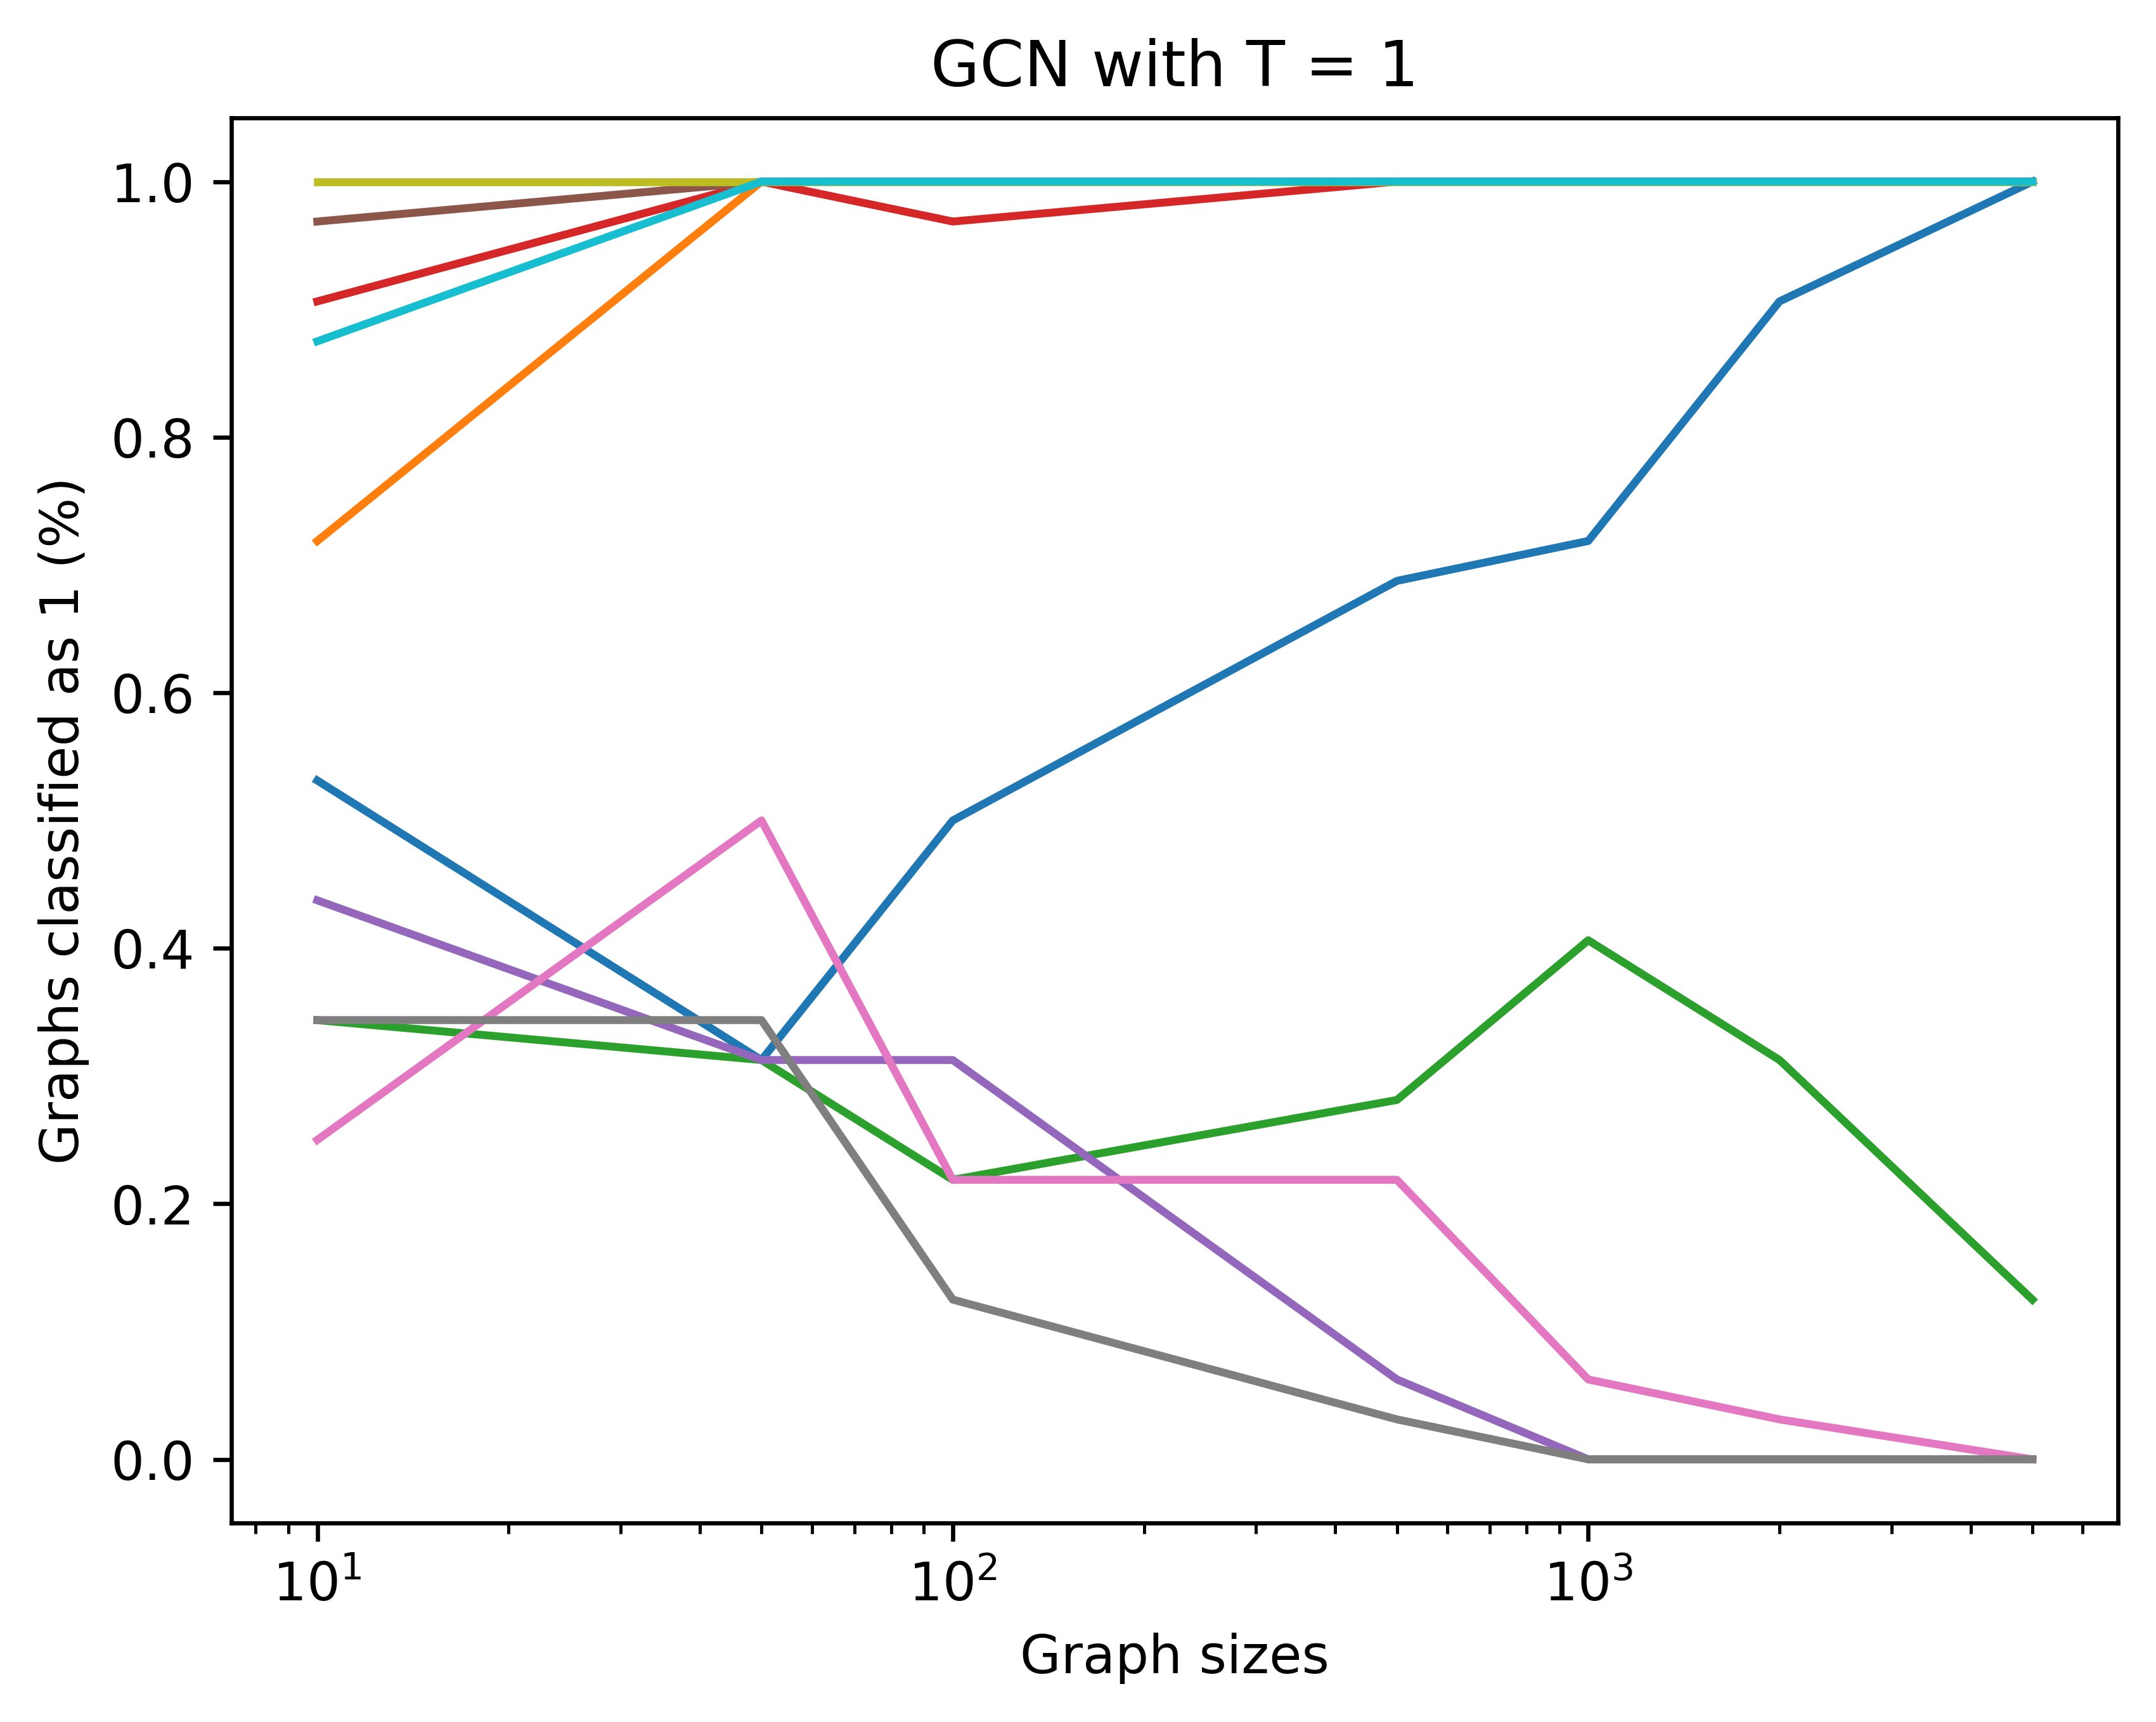

In [21]:
for y in csv_numLayer_1:
  y = [item/32 for item in y]
  plt.plot(x,y)# divide by 32

plt.xlabel('Graph sizes')
plt.ylabel('Graphs classified as 1 (%)')
plt.xscale("log")
plt.title(f'GCN with T = 1')
#plt.savefig('/Users/.../Desktop/.../visuals/normal1_no_layers_1')
plt.show()

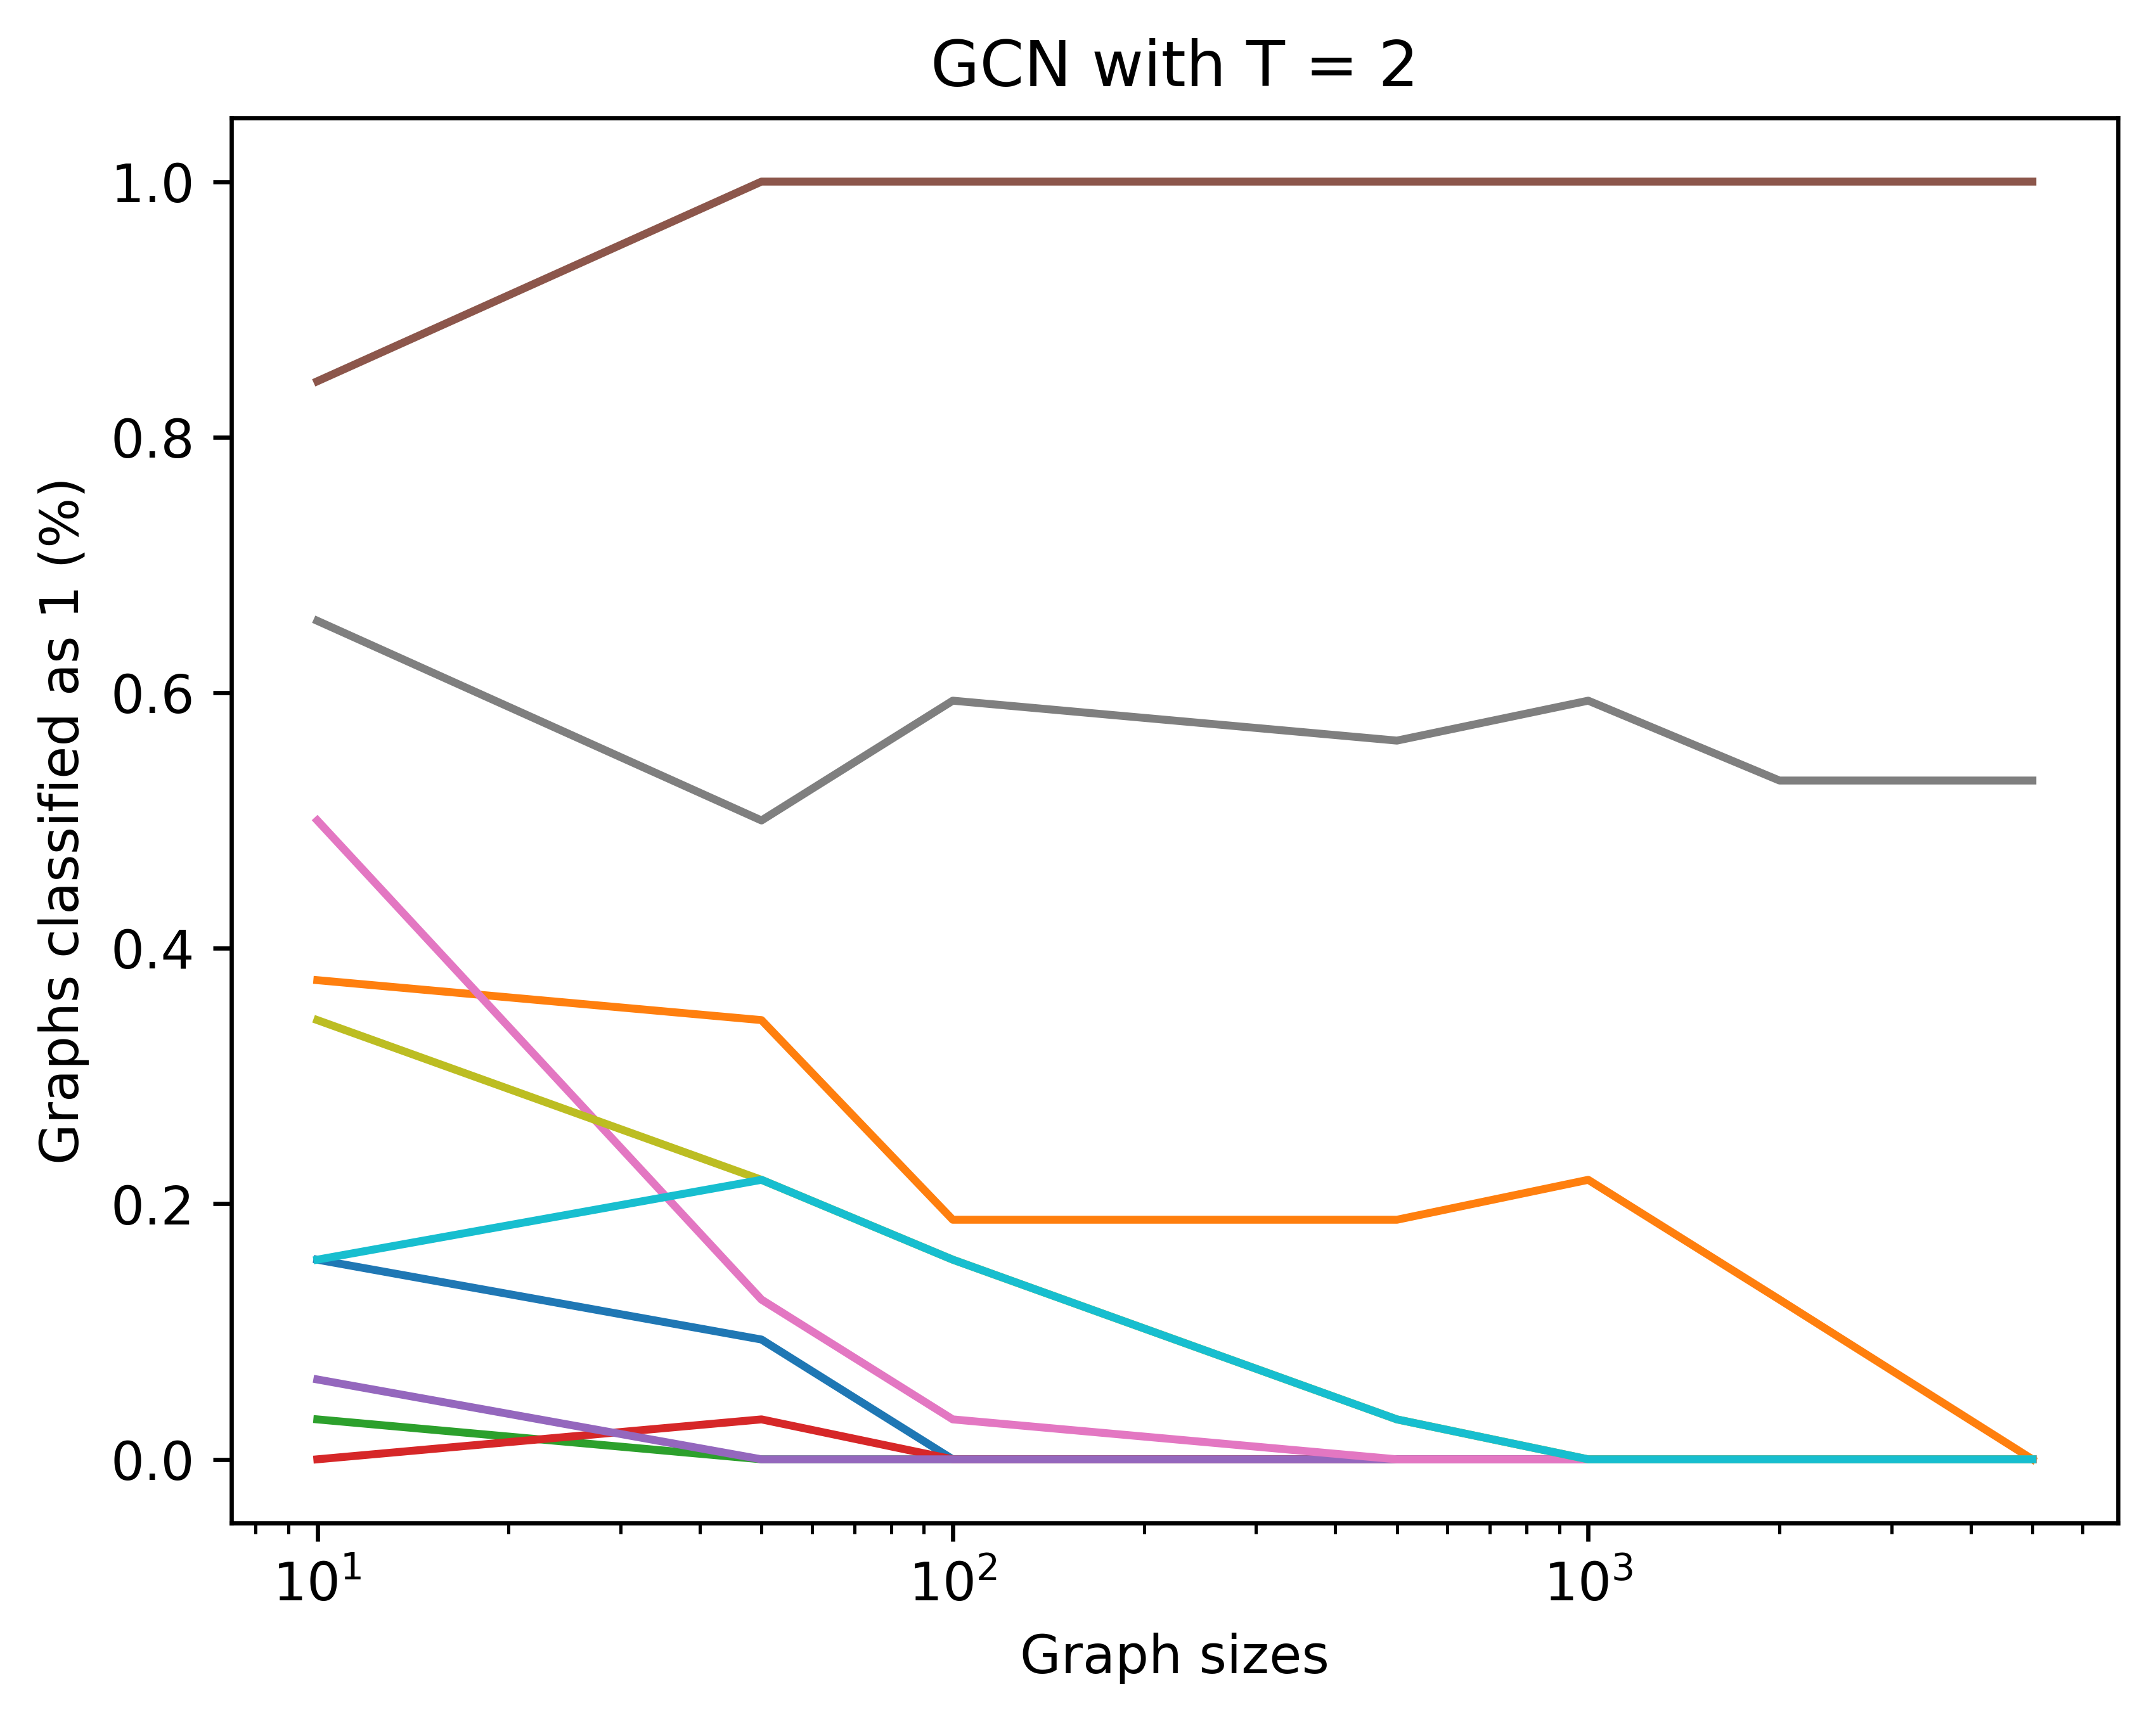

In [22]:
for y in csv_numLayer_2:
  y = [item/32 for item in y]
  plt.plot(x,y)# divide by 32

plt.xlabel('Graph sizes')
plt.ylabel('Graphs classified as 1 (%)')
plt.xscale("log")
plt.title(f'GCN with T = 2')
#plt.savefig('/Users/.../Desktop/.../visuals/normal1_no_layers_2')
plt.show()

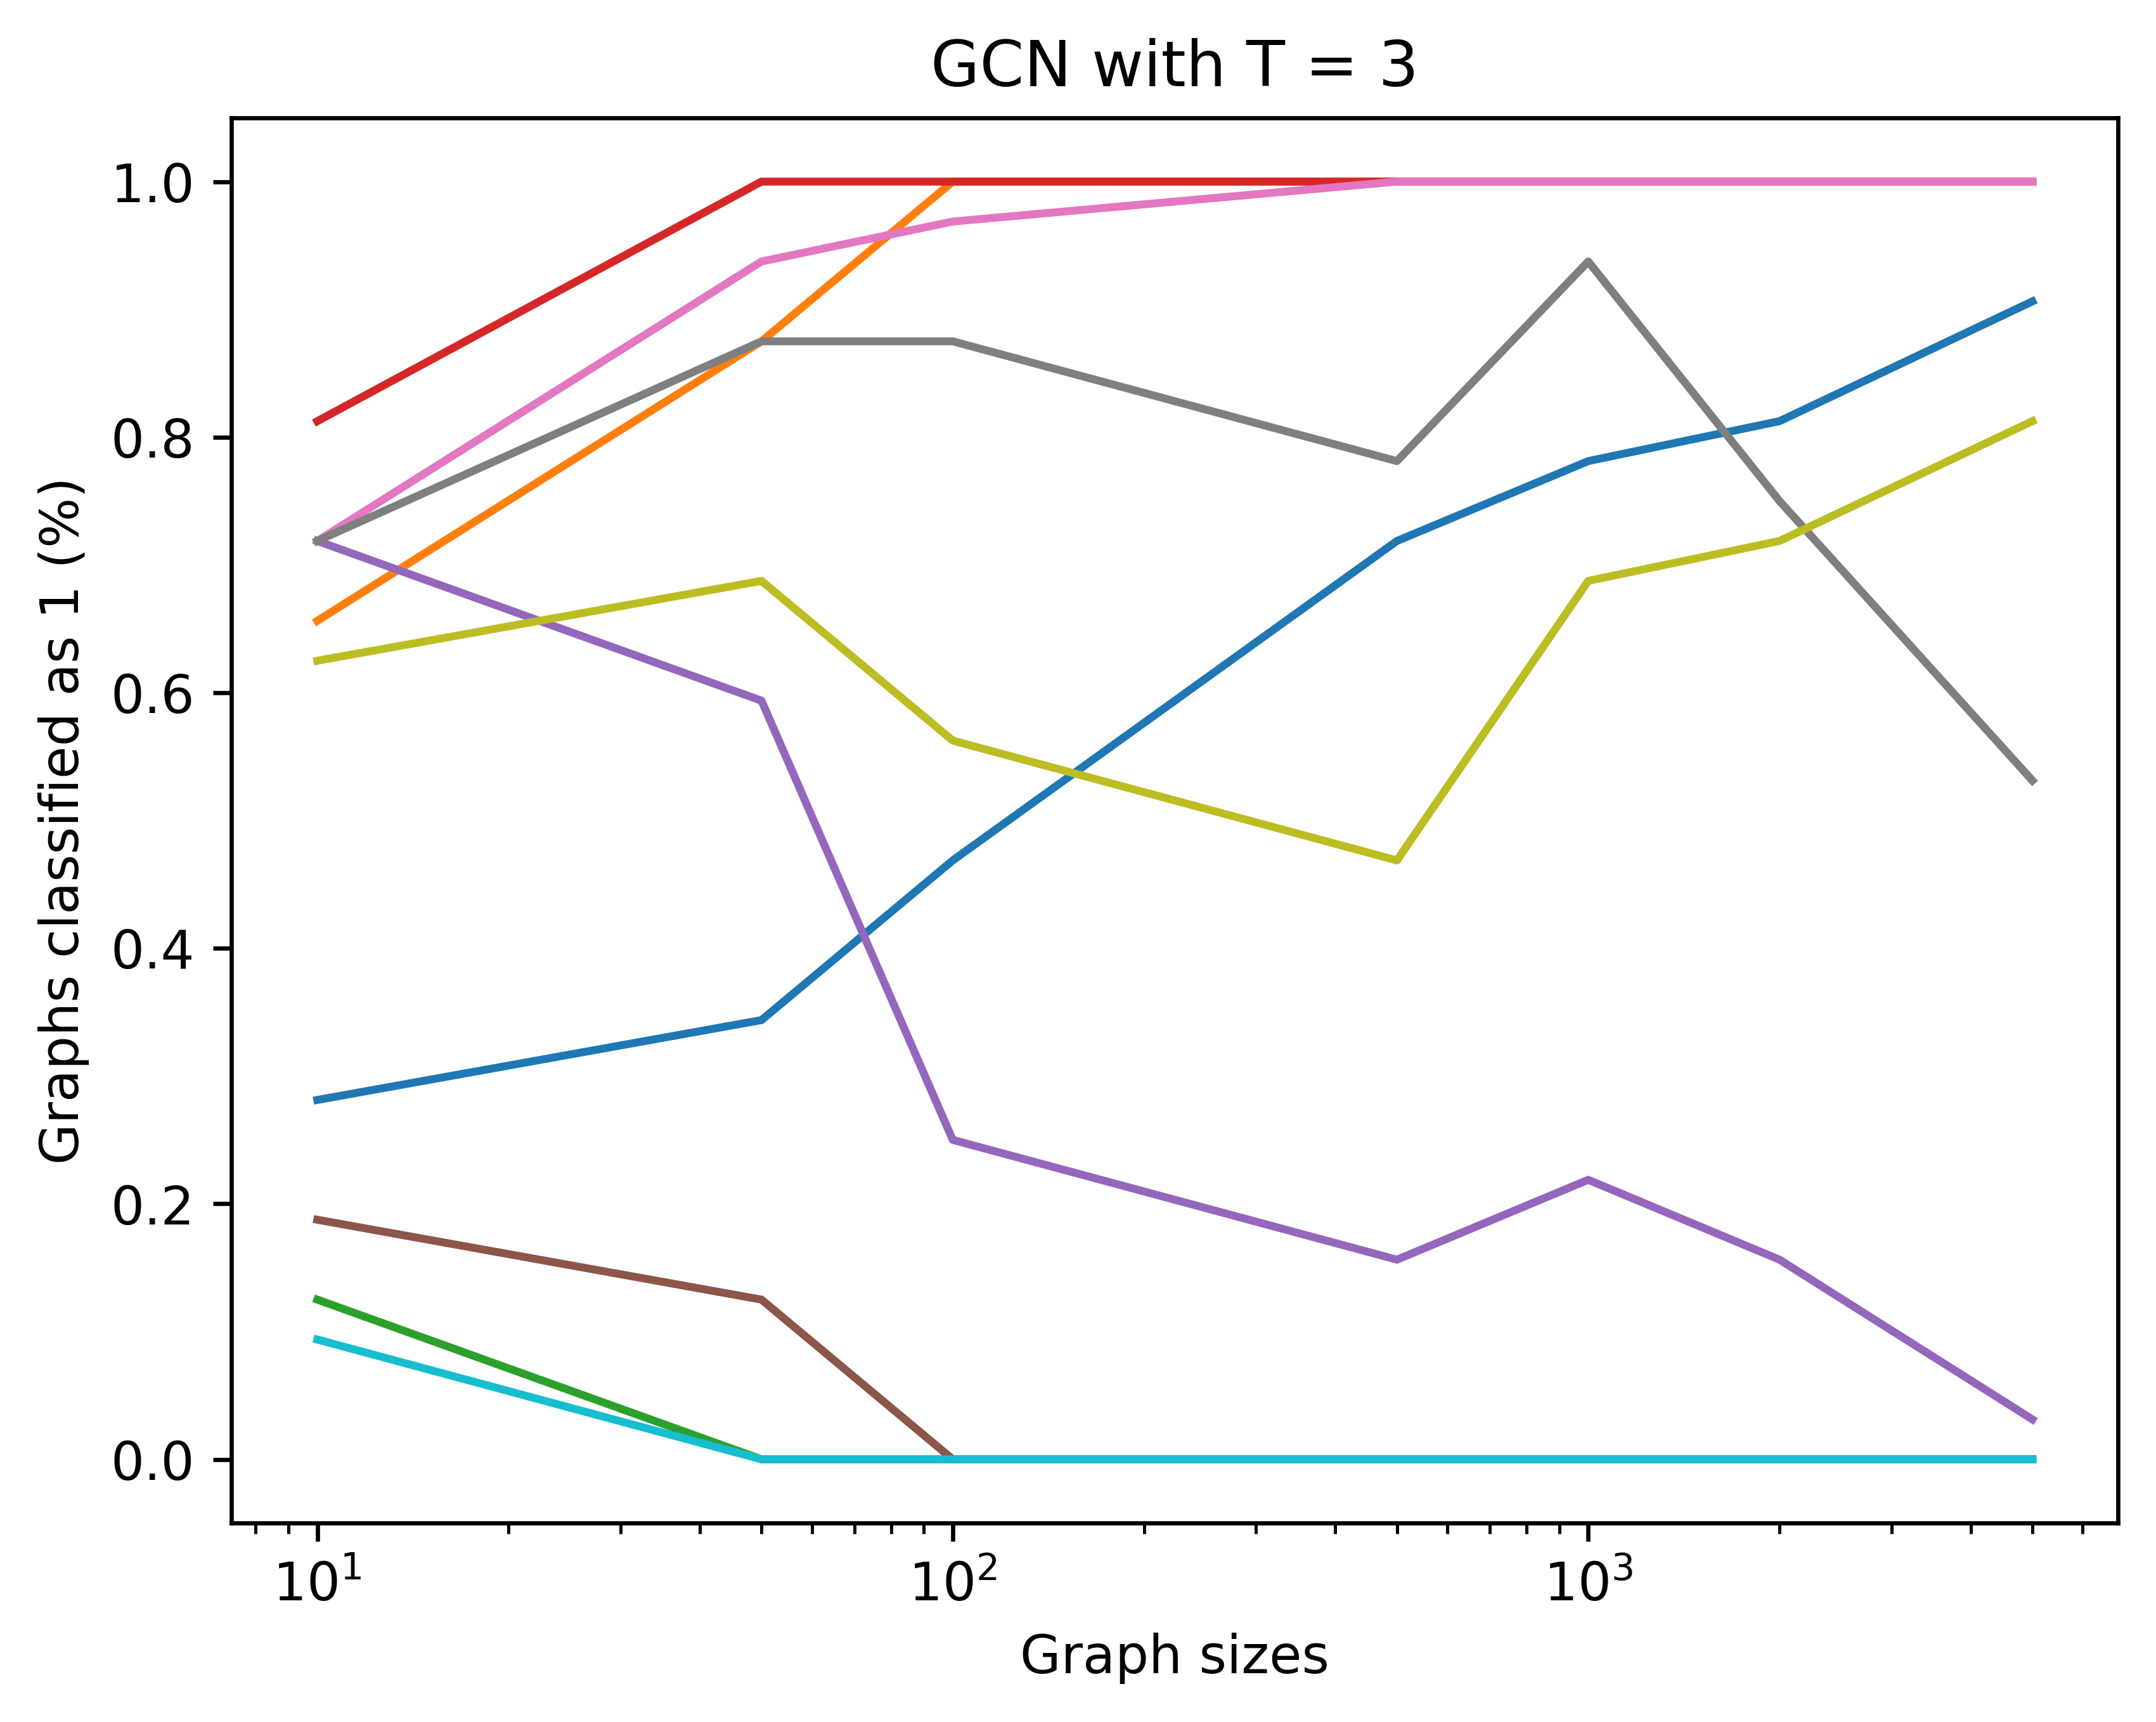

In [23]:
for y in csv_numLayer_3:
  y = [item/32 for item in y]
  plt.plot(x,y)# divide by 32

plt.xlabel('Graph sizes')
plt.ylabel('Graphs classified as 1 (%)')
plt.xscale("log")
plt.title(f'GCN with T = 3')
#plt.savefig('/Users/.../Desktop/.../visuals/normal1_no_layers_3')
plt.show()

In [24]:
csv

[[128, 0.5, 1, 0, [17, 10, 16, 22, 23, 29, 32]],
 [128, 0.5, 1, 1, [23, 32, 32, 32, 32, 32, 32]],
 [128, 0.5, 1, 2, [11, 10, 7, 9, 13, 10, 4]],
 [128, 0.5, 1, 3, [29, 32, 31, 32, 32, 32, 32]],
 [128, 0.5, 1, 4, [14, 10, 10, 2, 0, 0, 0]],
 [128, 0.5, 1, 5, [31, 32, 32, 32, 32, 32, 32]],
 [128, 0.5, 1, 6, [8, 16, 7, 7, 2, 1, 0]],
 [128, 0.5, 1, 7, [11, 11, 4, 1, 0, 0, 0]],
 [128, 0.5, 1, 8, [32, 32, 32, 32, 32, 32, 32]],
 [128, 0.5, 1, 9, [28, 32, 32, 32, 32, 32, 32]],
 [128, 0.5, 2, 0, [5, 3, 0, 0, 0, 0, 0]],
 [128, 0.5, 2, 1, [12, 11, 6, 6, 7, 4, 0]],
 [128, 0.5, 2, 2, [1, 0, 0, 0, 0, 0, 0]],
 [128, 0.5, 2, 3, [0, 1, 0, 0, 0, 0, 0]],
 [128, 0.5, 2, 4, [2, 0, 0, 0, 0, 0, 0]],
 [128, 0.5, 2, 5, [27, 32, 32, 32, 32, 32, 32]],
 [128, 0.5, 2, 6, [16, 4, 1, 0, 0, 0, 0]],
 [128, 0.5, 2, 7, [21, 16, 19, 18, 19, 17, 17]],
 [128, 0.5, 2, 8, [11, 7, 5, 1, 0, 0, 0]],
 [128, 0.5, 2, 9, [5, 7, 5, 1, 0, 0, 0]],
 [128, 0.5, 3, 0, [9, 11, 15, 23, 25, 26, 29]],
 [128, 0.5, 3, 1, [21, 28, 32, 32, 32, 32,

In [ ]:
import time
time.sleep(100000000)

KeyboardInterrupt: ignored